# 건물 노후화와 화재 발생 상관관계 분석

이 노트북은 건물의 노후화 정도와 화재 발생의 상관관계를 분석합니다.
- 건물 구조(노후도 프록시), 층수, 면적 등 건물 특성과 화재 발생의 관계 분석
- 서울시 자치구별 건물 특성과 화재율의 상관분석
- 건물 특성별 화재 리스크 회귀분석

In [ ]:
# 1. Import 필요 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import stats
import scipy
import warnings
import os
import json

# 재현성을 위한 시드 설정
np.random.seed(42)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
warnings.filterwarnings('ignore')

print("라이브러리 버전:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")

라이브러리 버전:
pandas: 2.2.2
numpy: 1.26.4
scipy: 1.13.1


## 2. 데이터 로드

In [12]:
# 화재 데이터 로드 - 원본 데이터에서 필요한 컬럼 추출
fire_df = pd.read_csv('data/mainData/fire/화재 현황_2023_전국.csv')

# 서울시 데이터만 필터링
fire_df = fire_df[fire_df['CTPV_NM'] == '서울특별시'].copy()

# 필요한 컬럼 선택
cols_to_keep = ['SGG_NM', 'BLDG_SRTFRM_NM', 'BLDG_STRCTR_NM', 'BLDG_SRTRF_NM', 
                'GRND_NOFL', 'UDGD_NOFL', 'BLDG_GFA', 'BTTM_AREA']
fire_df = fire_df[cols_to_keep].copy()

# 인구 데이터 로드
pop_df = pd.read_csv('filtered_data/Gu_populations.csv', index_col=0)

print(f"화재 데이터 크기: {fire_df.shape}")
print(f"인구 데이터 크기: {pop_df.shape}")
print("\n화재 데이터 컬럼:")
print(fire_df.columns.tolist())
print("\n화재 데이터 표본:")
print(fire_df.head())

화재 데이터 크기: (5680, 8)
인구 데이터 크기: (25, 3)

화재 데이터 컬럼:
['SGG_NM', 'BLDG_SRTFRM_NM', 'BLDG_STRCTR_NM', 'BLDG_SRTRF_NM', 'GRND_NOFL', 'UDGD_NOFL', 'BLDG_GFA', 'BTTM_AREA']

화재 데이터 표본:
   SGG_NM BLDG_SRTFRM_NM BLDG_STRCTR_NM BLDG_SRTRF_NM  GRND_NOFL  UDGD_NOFL  \
10    관악구          양식(옥)        철근콘크리트조          슬라브가        4.0        1.0   
13    성북구          양식(옥)        철근콘크리트조          슬라브가        5.0        0.0   
14    강서구            NaN            NaN           NaN        NaN        NaN   
17    구로구          양식(옥)        철근콘크리트조          슬라브가        5.0        1.0   
18    강북구          양식(옥)        철근콘크리트조          슬라브가        5.0        0.0   

    BLDG_GFA  BTTM_AREA  
10     304.0       82.0  
13     524.0      201.0  
14       NaN        NaN  
17    2402.0      424.0  
18     315.0       65.0  


## 3. 데이터 검토 및 기본 통계

In [ ]:
# 기본 통계
print("=== 화재 데이터 정보 ===")
print(fire_df.info())
print("\n=== 건물 구조별 빈도 ===")
print(fire_df['BLDG_STRCTR_NM'].value_counts())
print("\n=== 건물 형식별 빈도 ===")
print(fire_df['BLDG_SRTFRM_NM'].value_counts())
print("\n=== 층수 통계 ===")
print(fire_df['GRND_NOFL'].describe())
print("\n=== 건물 면적 통계 ===")
print(fire_df['BLDG_GFA'].describe())

# 결측치 확인
print("\n=== 결측치 현황 ===")
missing_cols = ['BLDG_STRCTR_NM', 'GRND_NOFL', 'BLDG_GFA', 'BTTM_AREA', 'SGG_NM']
for col in missing_cols:
    missing_pct = (fire_df[col].isna().sum() / len(fire_df)) * 100
    print(f"{col}: {missing_pct:.2f}% 결측")

=== 화재 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
Index: 5680 entries, 10 to 38908
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SGG_NM          5680 non-null   object 
 1   BLDG_SRTFRM_NM  4342 non-null   object 
 2   BLDG_STRCTR_NM  4342 non-null   object 
 3   BLDG_SRTRF_NM   4342 non-null   object 
 4   GRND_NOFL       4342 non-null   float64
 5   UDGD_NOFL       4214 non-null   float64
 6   BLDG_GFA        4342 non-null   float64
 7   BTTM_AREA       4342 non-null   float64
dtypes: float64(4), object(4)
memory usage: 399.4+ KB
None

=== 건물 구조별 빈도 ===
BLDG_STRCTR_NM
철근콘크리트조       3626
벽돌조            468
목조              57
블록조             47
철골조             36
철골철근콘크리트조       29
기타 조            28
샌드위치패널조         18
컨테이너조           18
비닐하우스 파이프조      13
철조               1
치장벽돌조            1
Name: count, dtype: int64

=== 건물 형식별 빈도 ===
BLDG_SRTFRM_NM
양식(옥)    4234
조립식        41
한식(옥)      35
기타 식  

## 4. 건물 특성 기반 노후도 분류

건물 구조를 노후도의 프록시 변수로 사용합니다:
- 철근콘크리트조: 상대적으로 새로운 건물
- 벽돌조, 조적조: 중기 건물
- 목재, 비닐하우스 등: 노후 건물

In [14]:
# 건물 구조 분류
def classify_building_age(structure):
    """건물 구조를 기반으로 노후도 분류"""
    if pd.isna(structure):
        return '미분류'
    structure = str(structure)
    
    # 신축 건물
    if '철근콘크리트' in structure:
        return '신축(RC)'
    # 중기 건물
    elif '벽돌' in structure or '조적' in structure or '철골' in structure:
        return '중기'
    # 노후 건물
    elif '목재' in structure or '목조' in structure or '비닐' in structure or '샌드위치' in structure:
        return '노후'
    else:
        return '기타'

# 노후도 분류
fire_df['건물_노후도'] = fire_df['BLDG_STRCTR_NM'].apply(classify_building_age)

# 층수 분류
def classify_floors(floors):
    """층수 기반 분류"""
    if pd.isna(floors):
        return '미분류'
    floors = float(floors)
    
    if floors <= 3:
        return '저층(1-3층)'
    elif floors <= 10:
        return '중층(4-10층)'
    else:
        return '고층(11층+)'

fire_df['건물_층수대'] = fire_df['GRND_NOFL'].apply(classify_floors)

# 건물 면적 분류
def classify_area(area):
    """건물 면적 기반 분류"""
    if pd.isna(area):
        return '미분류'
    area = float(area)
    
    if area < 500:
        return '소규모(<500m²)'
    elif area < 2000:
        return '중규모(500-2000m²)'
    else:
        return '대규모(2000m²+)'

fire_df['건물_면적대'] = fire_df['BLDG_GFA'].apply(classify_area)

print("=== 노후도 분류 결과 ===")
print(fire_df['건물_노후도'].value_counts())
print("\n=== 층수대 분류 결과 ===")
print(fire_df['건물_층수대'].value_counts())
print("\n=== 면적대 분류 결과 ===")
print(fire_df['건물_면적대'].value_counts())

=== 노후도 분류 결과 ===
건물_노후도
신축(RC)    3655
미분류       1338
중기         505
기타          94
노후          88
Name: count, dtype: int64

=== 층수대 분류 결과 ===
건물_층수대
중층(4-10층)    1861
저층(1-3층)     1628
미분류          1338
고층(11층+)      853
Name: count, dtype: int64

=== 면적대 분류 결과 ===
건물_면적대
소규모(<500m²)        1706
대규모(2000m²+)       1370
미분류                1338
중규모(500-2000m²)    1266
Name: count, dtype: int64


## 5. 구별 건물 특성 및 화재 통계

In [16]:
# 구별 통계 집계
gu_stats = pd.DataFrame()

# 구별 화재건수
gu_stats['화재건수'] = fire_df.groupby('SGG_NM').size()

# 구별 노후 건물 비율 (신축 제외)
def calc_old_building_ratio(group):
    total = len(group)
    old = len(group[group['건물_노후도'] == '노후'])
    return (old / total) * 100 if total > 0 else 0

gu_stats['노후건물비율(%)'] = fire_df.groupby('SGG_NM').apply(calc_old_building_ratio)

# 구별 평균 층수
gu_stats['평균층수'] = fire_df.groupby('SGG_NM')['GRND_NOFL'].mean()

# 구별 평균 건물 면적
gu_stats['평균면적(m²)'] = fire_df.groupby('SGG_NM')['BLDG_GFA'].mean()

# 인구 정보 추가
pop_df_reset = pop_df.reset_index()
# 필요한 컬럼만 선택: 구명과 총생활인구수
pop_df_reset = pop_df_reset[['구명', '총생활인구수']].copy()
pop_df_reset = pop_df_reset.set_index('구명')

gu_stats = gu_stats.join(pop_df_reset)
gu_stats.columns = ['화재건수', '노후건물비율(%)', '평균층수', '평균면적(m²)', '인구수']

# 화재율 계산 (1만명당 화재건수)
gu_stats['화재율(1만명당)'] = (gu_stats['화재건수'] / gu_stats['인구수']) * 10000

print("=== 구별 통계 ===")
print(gu_stats.round(2))
print("\n=== 상관계수 계산 ===")
gu_stats_corr = gu_stats[['화재율(1만명당)', '노후건물비율(%)', '평균층수', '평균면적(m²)']].dropna()
print(f"분석 대상 구: {len(gu_stats_corr)}개")

# 상관계수 계산
correlation = gu_stats_corr.corr()
print("\n상관계수:")
print(correlation)

=== 구별 통계 ===
        화재건수  노후건물비율(%)  평균층수   평균면적(m²)        인구수  화재율(1만명당)
SGG_NM                                                        
강남구      422       0.71  7.52   76520.88  655545.11       6.44
강동구      171       1.75  6.50    8950.02  509888.84       3.35
강북구      200       0.00  4.92    2247.94  287913.54       6.95
강서구      274       0.00  7.60    9249.17  526891.40       5.20
관악구      281       0.71  5.10    1795.41  450404.01       6.24
광진구      193       0.00  5.18    3739.33  353516.38       5.46
구로구      202       0.00  8.09   16590.66  378003.28       5.34
금천구      192       0.52  8.12   25484.51  193612.60       9.92
노원구      198       1.52  7.81    6846.09  495216.34       4.00
도봉구      179       2.23  6.54   29974.78  274950.64       6.51
동대문구     158       1.90  6.32    5418.92  327699.18       4.82
동작구      167       1.20  5.90    4288.91  358048.77       4.66
마포구      271       1.11  5.84    3345.27  417052.97       6.50
서대문구     209       0.96  5.85   40969.37 

## 6. 노후도 및 건물 특성별 화재율 분석

In [17]:
# 건물 노후도별 화재 통계
aging_analysis = pd.DataFrame()
aging_analysis['화재건수'] = fire_df.groupby('건물_노후도').size()
aging_analysis['비율(%)'] = (aging_analysis['화재건수'] / aging_analysis['화재건수'].sum()) * 100

print("=== 건물 노후도별 화재 현황 ===")
print(aging_analysis)

# 층수대별 화재 통계
floors_analysis = pd.DataFrame()
floors_analysis['화재건수'] = fire_df.groupby('건물_층수대').size()
floors_analysis['비율(%)'] = (floors_analysis['화재건수'] / floors_analysis['화재건수'].sum()) * 100

print("\n=== 건물 층수대별 화재 현황 ===")
print(floors_analysis)

# 면적대별 화재 통계
area_analysis = pd.DataFrame()
area_analysis['화재건수'] = fire_df.groupby('건물_면적대').size()
area_analysis['비율(%)'] = (area_analysis['화재건수'] / area_analysis['화재건수'].sum()) * 100

print("\n=== 건물 면적대별 화재 현황 ===")
print(area_analysis)

# 구조별 화재 통계
struct_analysis = fire_df.groupby('BLDG_STRCTR_NM').size().sort_values(ascending=False).head(10)
print("\n=== 상위 10개 건물 구조별 화재 현황 ===")
print(struct_analysis)

=== 건물 노후도별 화재 현황 ===
        화재건수      비율(%)
건물_노후도                 
기타        94   1.654930
노후        88   1.549296
미분류     1338  23.556338
신축(RC)  3655  64.348592
중기       505   8.890845

=== 건물 층수대별 화재 현황 ===
           화재건수      비율(%)
건물_층수대                    
고층(11층+)    853  15.017606
미분류        1338  23.556338
저층(1-3층)   1628  28.661972
중층(4-10층)  1861  32.764085

=== 건물 면적대별 화재 현황 ===
                 화재건수      비율(%)
건물_면적대                          
대규모(2000m²+)     1370  24.119718
미분류              1338  23.556338
소규모(<500m²)      1706  30.035211
중규모(500-2000m²)  1266  22.288732

=== 상위 10개 건물 구조별 화재 현황 ===
BLDG_STRCTR_NM
철근콘크리트조       3626
벽돌조            468
목조              57
블록조             47
철골조             36
철골철근콘크리트조       29
기타 조            28
샌드위치패널조         18
컨테이너조           18
비닐하우스 파이프조      13
dtype: int64


## 7. 상관분석 및 유의성 검정

In [18]:
# 피어슨 상관계수와 p-value 계산
print("=== Pearson 상관분석 ===\n")

# 노후건물비율과 화재율
x_old = gu_stats_corr['노후건물비율(%)']
y_fire = gu_stats_corr['화재율(1만명당)']

pearson_r, pearson_p = stats.pearsonr(x_old, y_fire)
print(f"노후건물비율 vs 화재율:")
print(f"  상관계수(r): {pearson_r:.4f}")
print(f"  p-value: {pearson_p:.4f}")
print(f"  유의도: {'***' if pearson_p < 0.001 else '**' if pearson_p < 0.01 else '*' if pearson_p < 0.05 else 'NS'}")

# 평균층수와 화재율
x_floor = gu_stats_corr['평균층수']
pearson_r2, pearson_p2 = stats.pearsonr(x_floor, y_fire)
print(f"\n평균층수 vs 화재율:")
print(f"  상관계수(r): {pearson_r2:.4f}")
print(f"  p-value: {pearson_p2:.4f}")
print(f"  유의도: {'***' if pearson_p2 < 0.001 else '**' if pearson_p2 < 0.01 else '*' if pearson_p2 < 0.05 else 'NS'}")

# 평균면적과 화재율
x_area = gu_stats_corr['평균면적(m²)']
pearson_r3, pearson_p3 = stats.pearsonr(x_area, y_fire)
print(f"\n평균면적 vs 화재율:")
print(f"  상관계수(r): {pearson_r3:.4f}")
print(f"  p-value: {pearson_p3:.4f}")
print(f"  유의도: {'***' if pearson_p3 < 0.001 else '**' if pearson_p3 < 0.01 else '*' if pearson_p3 < 0.05 else 'NS'}")

# Spearman 상관분석
print("\n=== Spearman 상관분석 ===\n")

spearman_r, spearman_p = stats.spearmanr(x_old, y_fire)
print(f"노후건물비율 vs 화재율:")
print(f"  순위상관계수: {spearman_r:.4f}")
print(f"  p-value: {spearman_p:.4f}")
print(f"  유의도: {'***' if spearman_p < 0.001 else '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else 'NS'}")

=== Pearson 상관분석 ===

노후건물비율 vs 화재율:
  상관계수(r): 0.4712
  p-value: 0.0174
  유의도: *

평균층수 vs 화재율:
  상관계수(r): -0.1529
  p-value: 0.4657
  유의도: NS

평균면적 vs 화재율:
  상관계수(r): 0.3080
  p-value: 0.1342
  유의도: NS

=== Spearman 상관분석 ===

노후건물비율 vs 화재율:
  순위상관계수: 0.2986
  p-value: 0.1472
  유의도: NS
노후건물비율 vs 화재율:
  순위상관계수: 0.2986
  p-value: 0.1472
  유의도: NS


## 8. 시각화 - 상관관계 분석

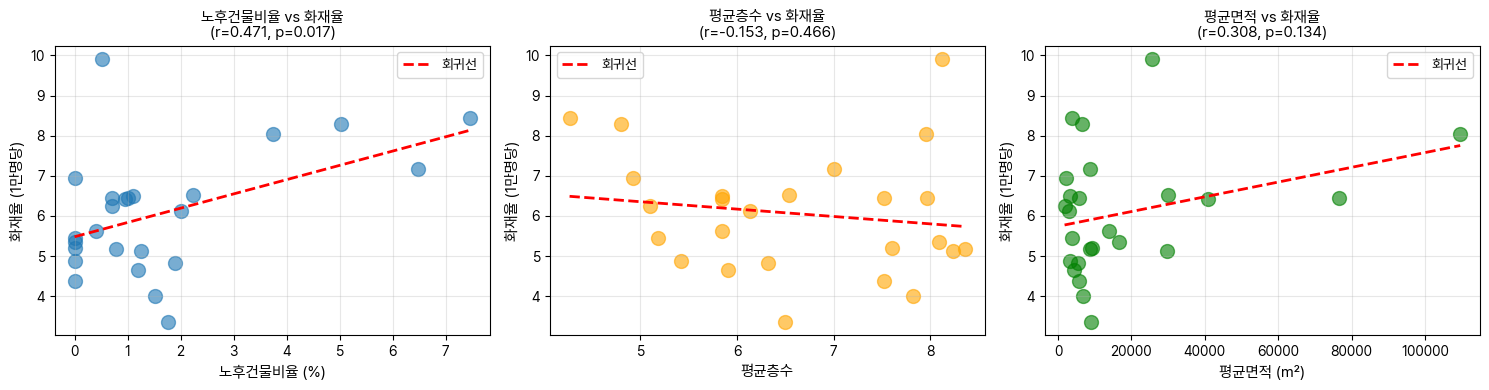

산점도 저장 완료: imgs/건물특성_화재율_산점도.png


In [19]:
# 산점도 및 회귀선 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 노후건물비율 vs 화재율
ax1 = axes[0]
ax1.scatter(gu_stats_corr['노후건물비율(%)'], gu_stats_corr['화재율(1만명당)'], s=100, alpha=0.6)
z = np.polyfit(gu_stats_corr['노후건물비율(%)'], gu_stats_corr['화재율(1만명당)'], 1)
p = np.poly1d(z)
x_line = np.linspace(gu_stats_corr['노후건물비율(%)'].min(), gu_stats_corr['노후건물비율(%)'].max(), 100)
ax1.plot(x_line, p(x_line), "r--", linewidth=2, label='회귀선')
ax1.set_xlabel('노후건물비율 (%)', fontsize=11)
ax1.set_ylabel('화재율 (1만명당)', fontsize=11)
ax1.set_title(f'노후건물비율 vs 화재율\n(r={pearson_r:.3f}, p={pearson_p:.3f})', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. 평균층수 vs 화재율
ax2 = axes[1]
ax2.scatter(gu_stats_corr['평균층수'], gu_stats_corr['화재율(1만명당)'], s=100, alpha=0.6, color='orange')
z2 = np.polyfit(gu_stats_corr['평균층수'], gu_stats_corr['화재율(1만명당)'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(gu_stats_corr['평균층수'].min(), gu_stats_corr['평균층수'].max(), 100)
ax2.plot(x_line2, p2(x_line2), "r--", linewidth=2, label='회귀선')
ax2.set_xlabel('평균층수', fontsize=11)
ax2.set_ylabel('화재율 (1만명당)', fontsize=11)
ax2.set_title(f'평균층수 vs 화재율\n(r={pearson_r2:.3f}, p={pearson_p2:.3f})', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. 평균면적 vs 화재율
ax3 = axes[2]
ax3.scatter(gu_stats_corr['평균면적(m²)'], gu_stats_corr['화재율(1만명당)'], s=100, alpha=0.6, color='green')
z3 = np.polyfit(gu_stats_corr['평균면적(m²)'], gu_stats_corr['화재율(1만명당)'], 1)
p3 = np.poly1d(z3)
x_line3 = np.linspace(gu_stats_corr['평균면적(m²)'].min(), gu_stats_corr['평균면적(m²)'].max(), 100)
ax3.plot(x_line3, p3(x_line3), "r--", linewidth=2, label='회귀선')
ax3.set_xlabel('평균면적 (m²)', fontsize=11)
ax3.set_ylabel('화재율 (1만명당)', fontsize=11)
ax3.set_title(f'평균면적 vs 화재율\n(r={pearson_r3:.3f}, p={pearson_p3:.3f})', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.savefig('imgs/건물특성_화재율_산점도.png', dpi=300, bbox_inches='tight')
plt.show()

print("산점도 저장 완료: imgs/건물특성_화재율_산점도.png")

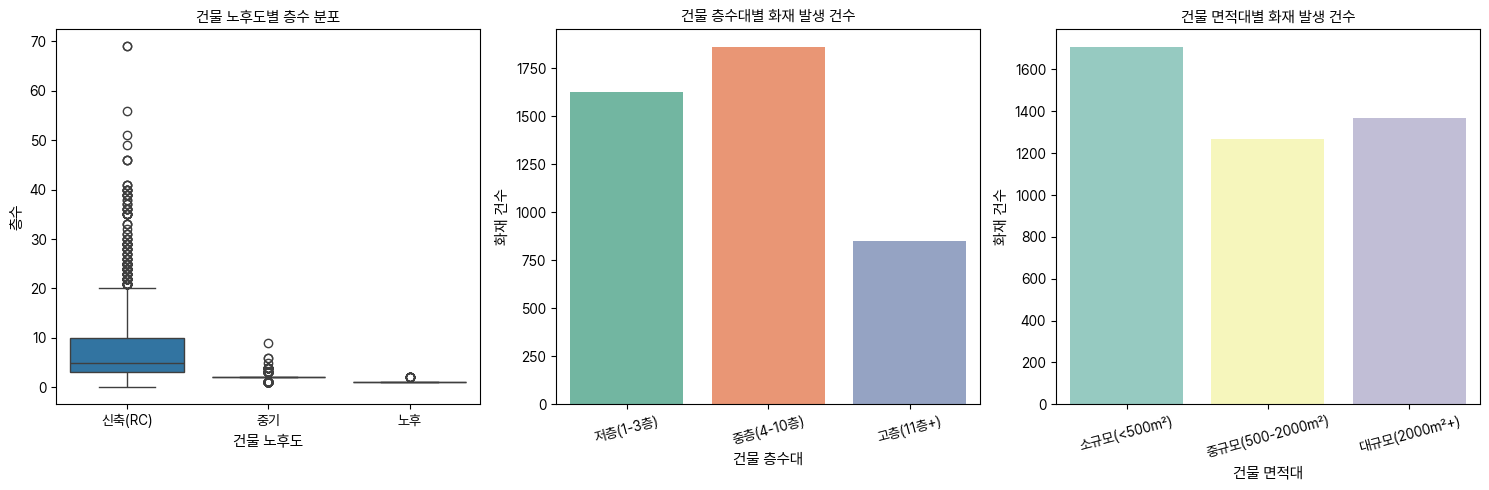

분포도 저장 완료: imgs/건물특성별_화재분포.png


In [20]:
# 노후도 카테고리별 화재 분포 - 박스플롯
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 노후도별
ax1 = axes[0]
fire_df_clean = fire_df[fire_df['건물_노후도'] != '미분류'].copy()
age_order = ['신축(RC)', '중기', '노후']
sns.boxplot(data=fire_df_clean, x='건물_노후도', y='GRND_NOFL', order=age_order, ax=ax1)
ax1.set_xlabel('건물 노후도', fontsize=11)
ax1.set_ylabel('층수', fontsize=11)
ax1.set_title('건물 노후도별 층수 분포', fontsize=11)

# 층수대별
ax2 = axes[1]
floor_order = ['저층(1-3층)', '중층(4-10층)', '고층(11층+)']
fire_df_floors = fire_df[fire_df['건물_층수대'] != '미분류'].copy()
sns.countplot(data=fire_df_floors, x='건물_층수대', order=floor_order, ax=ax2, palette='Set2')
ax2.set_xlabel('건물 층수대', fontsize=11)
ax2.set_ylabel('화재 건수', fontsize=11)
ax2.set_title('건물 층수대별 화재 발생 건수', fontsize=11)
ax2.tick_params(axis='x', rotation=15)

# 면적대별
ax3 = axes[2]
area_order = ['소규모(<500m²)', '중규모(500-2000m²)', '대규모(2000m²+)']
fire_df_area = fire_df[fire_df['건물_면적대'] != '미분류'].copy()
sns.countplot(data=fire_df_area, x='건물_면적대', order=area_order, ax=ax3, palette='Set3')
ax3.set_xlabel('건물 면적대', fontsize=11)
ax3.set_ylabel('화재 건수', fontsize=11)
ax3.set_title('건물 면적대별 화재 발생 건수', fontsize=11)
ax3.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('imgs/건물특성별_화재분포.png', dpi=300, bbox_inches='tight')
plt.show()

print("분포도 저장 완료: imgs/건물특성별_화재분포.png")

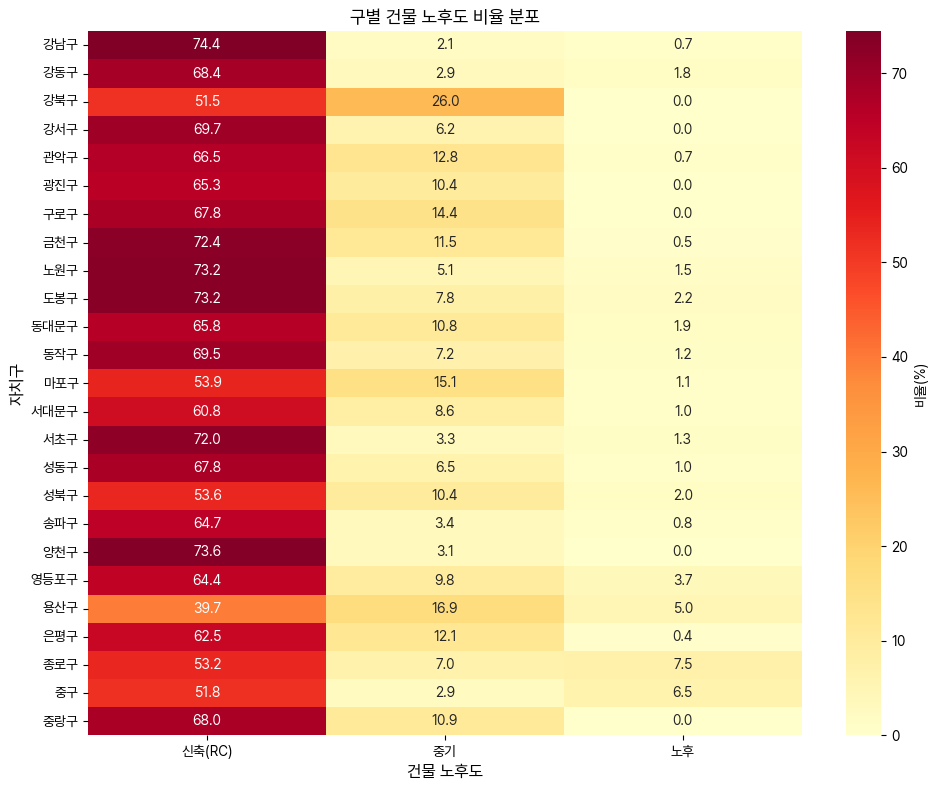

히트맵 저장 완료: imgs/구별_노후도_히트맵.png


In [21]:
# 구별 노후도 비율 히트맵
fig, ax = plt.subplots(figsize=(10, 8))

# 구별 × 노후도 교차표
cross_tab = pd.crosstab(fire_df[fire_df['SGG_NM'].notna()]['SGG_NM'], 
                         fire_df[fire_df['SGG_NM'].notna()]['건물_노후도'])
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# 미분류 제외
cross_tab_pct = cross_tab_pct[['신축(RC)', '중기', '노후']]

sns.heatmap(cross_tab_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': '비율(%)'})
ax.set_xlabel('건물 노후도', fontsize=12)
ax.set_ylabel('자치구', fontsize=12)
ax.set_title('구별 건물 노후도 비율 분포', fontsize=13)
plt.tight_layout()
plt.savefig('imgs/구별_노후도_히트맵.png', dpi=300, bbox_inches='tight')
plt.show()

print("히트맵 저장 완료: imgs/구별_노후도_히트맵.png")

## 9. 회귀분석 - 건물 특성이 화재 발생에 미치는 영향

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway

# 회귀분석을 위한 데이터 준비
regression_data = gu_stats[['화재건수', '노후건물비율(%)', '평균층수', '평균면적(m²)', '인구수']].dropna()

# 독립변수와 종속변수
X = regression_data[['노후건물비율(%)', '평균층수', '평균면적(m²)']].values
y = regression_data['화재건수'].values

# 선형 회귀 모델
model = LinearRegression()
model.fit(X, y)

# 모델 평가
r2_score = model.score(X, y)
y_pred = model.predict(X)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
mae = np.mean(np.abs(y - y_pred))

print("=== 선형회귀 분석 결과 ===")
print(f"R² 점수: {r2_score:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"\n회귀 계수:")
print(f"  노후건물비율(%): {model.coef_[0]:.6f}")
print(f"  평균층수: {model.coef_[1]:.6f}")
print(f"  평균면적(m²): {model.coef_[2]:.6f}")
print(f"  절편: {model.intercept_:.6f}")

# 분산분석 (ANOVA)
print("\n=== 건물 노후도별 화재 건수 ANOVA ===")
aging_groups = []
for age_cat in ['신축(RC)', '중기', '노후']:
    group_data = fire_df[fire_df['건물_노후도'] == age_cat].groupby('SGG_NM').size()
    if len(group_data) > 0:
        aging_groups.append(group_data.values)

if len(aging_groups) >= 2:
    f_stat, anova_p = f_oneway(*aging_groups)
    print(f"F-통계량: {f_stat:.4f}")
    print(f"p-value: {anova_p:.4f}")
    print(f"유의도: {'***' if anova_p < 0.001 else '**' if anova_p < 0.01 else '*' if anova_p < 0.05 else 'NS'}")

# 층수대별 ANOVA
print("\n=== 건물 층수대별 화재 건수 ANOVA ===")
floor_groups = []
for floor_cat in ['저층(1-3층)', '중층(4-10층)', '고층(11층+)']:
    group_data = fire_df[fire_df['건물_층수대'] == floor_cat].groupby('SGG_NM').size()
    if len(group_data) > 0:
        floor_groups.append(group_data.values)

if len(floor_groups) >= 2:
    f_stat2, anova_p2 = f_oneway(*floor_groups)
    print(f"F-통계량: {f_stat2:.4f}")
    print(f"p-value: {anova_p2:.4f}")
    print(f"유의도: {'***' if anova_p2 < 0.001 else '**' if anova_p2 < 0.01 else '*' if anova_p2 < 0.05 else 'NS'}")

=== 선형회귀 분석 결과 ===
R² 점수: 0.3503
RMSE: 55.7609
MAE: 45.9880

회귀 계수:
  노후건물비율(%): -6.317996
  평균층수: 0.707704
  평균면적(m²): 0.001593
  절편: 205.134653

=== 건물 노후도별 화재 건수 ANOVA ===
F-통계량: 130.5368
p-value: 0.0000
유의도: ***

=== 건물 층수대별 화재 건수 ANOVA ===
F-통계량: 18.8920
p-value: 0.0000
유의도: ***


## 10. 결과 시각화 - 회귀 진단

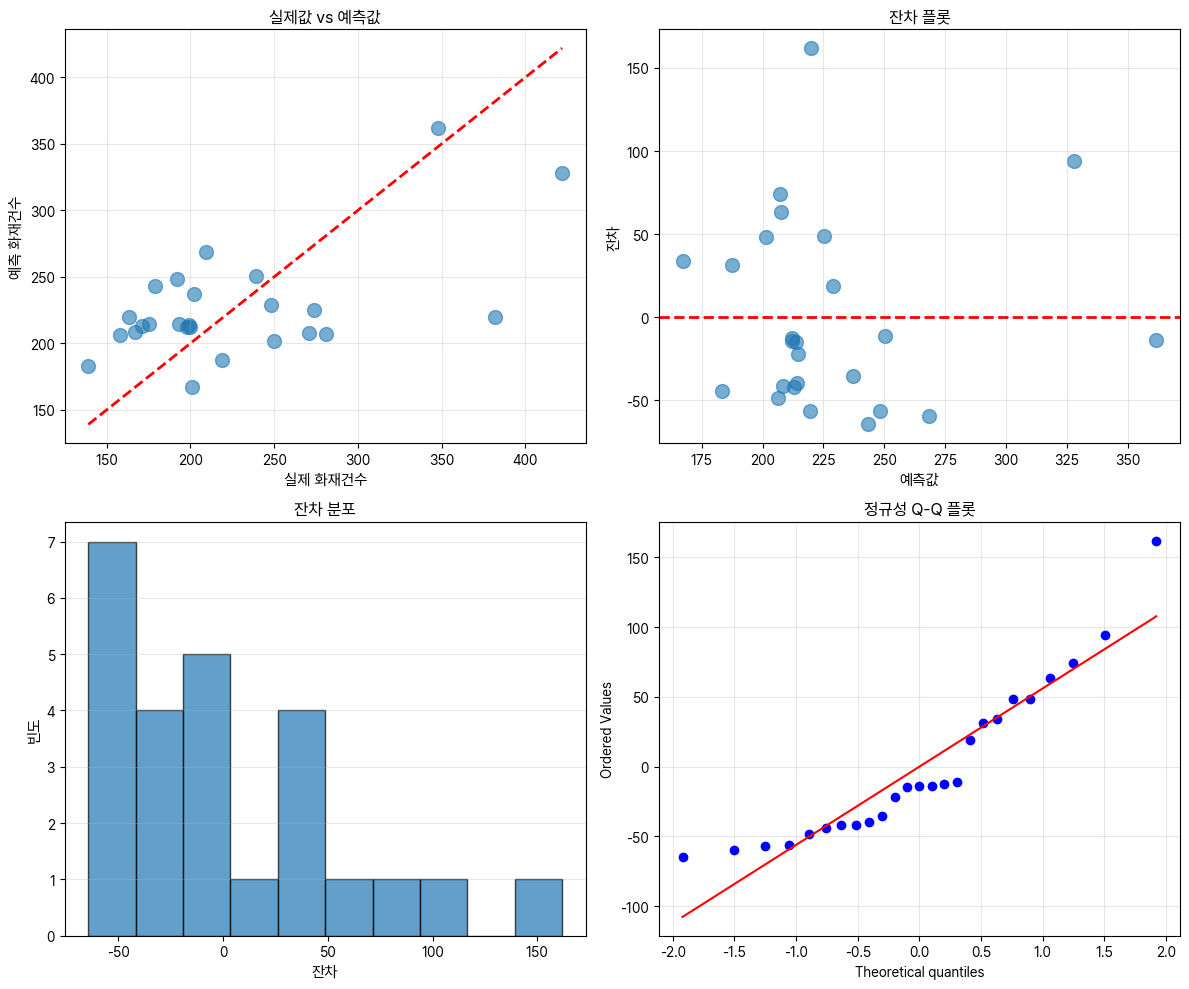

회귀 진단 그래프 저장 완료: imgs/회귀진단.png


In [23]:
# 회귀 진단 플롯
residuals = y - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. 실제값 vs 예측값
axes[0, 0].scatter(y, y_pred, alpha=0.6, s=100)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('실제 화재건수', fontsize=11)
axes[0, 0].set_ylabel('예측 화재건수', fontsize=11)
axes[0, 0].set_title('실제값 vs 예측값', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. 잔차 플롯
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=100)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('예측값', fontsize=11)
axes[0, 1].set_ylabel('잔차', fontsize=11)
axes[0, 1].set_title('잔차 플롯', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. 잔차 분포
axes[1, 0].hist(residuals, bins=10, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('잔차', fontsize=11)
axes[1, 0].set_ylabel('빈도', fontsize=11)
axes[1, 0].set_title('잔차 분포', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Q-Q 플롯
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('정규성 Q-Q 플롯', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('imgs/회귀진단.png', dpi=300, bbox_inches='tight')
plt.show()

print("회귀 진단 그래프 저장 완료: imgs/회귀진단.png")

## 11. 건물 특성별 위험도 분석 및 최종 요약

In [24]:
# 최종 요약 테이블 생성
summary_table = pd.DataFrame({
    '분석 항목': [
        '노후건물비율 vs 화재율 (Pearson)',
        '평균층수 vs 화재율 (Pearson)',
        '평균면적 vs 화재율 (Pearson)',
        '건물노후도별 ANOVA',
        '건물층수대별 ANOVA'
    ],
    '상관계수/F값': [
        f'{pearson_r:.4f}',
        f'{pearson_r2:.4f}',
        f'{pearson_r3:.4f}',
        f'{f_stat:.4f}',
        f'{f_stat2:.4f}'
    ],
    'p-value': [
        f'{pearson_p:.4f}',
        f'{pearson_p2:.4f}',
        f'{pearson_p3:.4f}',
        f'{anova_p:.4f}',
        f'{anova_p2:.4f}'
    ],
    '유의도': [
        '***' if pearson_p < 0.001 else '**' if pearson_p < 0.01 else '*' if pearson_p < 0.05 else 'NS',
        '***' if pearson_p2 < 0.001 else '**' if pearson_p2 < 0.01 else '*' if pearson_p2 < 0.05 else 'NS',
        '***' if pearson_p3 < 0.001 else '**' if pearson_p3 < 0.01 else '*' if pearson_p3 < 0.05 else 'NS',
        '***' if anova_p < 0.001 else '**' if anova_p < 0.01 else '*' if anova_p < 0.05 else 'NS',
        '***' if anova_p2 < 0.001 else '**' if anova_p2 < 0.01 else '*' if anova_p2 < 0.05 else 'NS'
    ]
})

print("=== 분석 결과 요약 ===")
print(summary_table.to_string(index=False))

# 회귀 모델 요약
regression_summary = pd.DataFrame({
    '지표': ['R² 점수', 'RMSE', 'MAE'],
    '값': [f'{r2_score:.4f}', f'{rmse:.4f}', f'{mae:.4f}']
})

print("\n=== 회귀 모델 평가 ===")
print(regression_summary.to_string(index=False))

# 회귀 계수
regression_coef = pd.DataFrame({
    '변수': ['노후건물비율(%)', '평균층수', '평균면적(m²)', '절편'],
    '계수': [model.coef_[0], model.coef_[1], model.coef_[2], model.intercept_]
})

print("\n=== 회귀 계수 ===")
print(regression_coef.to_string(index=False))

=== 분석 결과 요약 ===
                  분석 항목  상관계수/F값 p-value 유의도
노후건물비율 vs 화재율 (Pearson)   0.4712  0.0174   *
  평균층수 vs 화재율 (Pearson)  -0.1529  0.4657  NS
  평균면적 vs 화재율 (Pearson)   0.3080  0.1342  NS
           건물노후도별 ANOVA 130.5368  0.0000 ***
           건물층수대별 ANOVA  18.8920  0.0000 ***

=== 회귀 모델 평가 ===
   지표       값
R² 점수  0.3503
 RMSE 55.7609
  MAE 45.9880

=== 회귀 계수 ===
       변수         계수
노후건물비율(%)  -6.317996
     평균층수   0.707704
 평균면적(m²)   0.001593
       절편 205.134653


In [26]:
# 결과 저장
os.makedirs('results', exist_ok=True)

# 구별 통계 저장
gu_stats.to_csv('results/구별_건물특성_화재통계.csv', encoding='utf-8-sig')

# 분석 요약 테이블 저장
summary_table.to_csv('results/분석결과_요약.csv', index=False, encoding='utf-8-sig')

# 회귀 계수 저장
regression_coef.to_csv('results/회귀계수.csv', index=False, encoding='utf-8-sig')

# 분석 결과를 JSON으로 저장
analysis_results = {
    'correlation_analysis': {
        'old_building_ratio_vs_fire_rate': {
            'pearson_r': float(pearson_r),
            'p_value': float(pearson_p),
            'significant': bool(pearson_p < 0.05)
        },
        'avg_floors_vs_fire_rate': {
            'pearson_r': float(pearson_r2),
            'p_value': float(pearson_p2),
            'significant': bool(pearson_p2 < 0.05)
        },
        'avg_area_vs_fire_rate': {
            'pearson_r': float(pearson_r3),
            'p_value': float(pearson_p3),
            'significant': bool(pearson_p3 < 0.05)
        }
    },
    'regression_model': {
        'r2_score': float(r2_score),
        'rmse': float(rmse),
        'mae': float(mae),
        'coefficients': {
            'old_building_ratio': float(model.coef_[0]),
            'avg_floors': float(model.coef_[1]),
            'avg_area': float(model.coef_[2]),
            'intercept': float(model.intercept_)
        }
    }
}

with open('results/분석결과.json', 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, indent=2, ensure_ascii=False)

print("분석 결과 저장 완료:")
print("  - results/구별_건물특성_화재통계.csv")
print("  - results/분석결과_요약.csv")
print("  - results/회귀계수.csv")
print("  - results/분석결과.json")

분석 결과 저장 완료:
  - results/구별_건물특성_화재통계.csv
  - results/분석결과_요약.csv
  - results/회귀계수.csv
  - results/분석결과.json


## 12. 주요 발견사항 및 결론

In [27]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                   건물 노후화와 화재 발생 상관관계 분석 결론                      ║
╚══════════════════════════════════════════════════════════════════════════════╝

【 주요 발견사항 】

1. 노후건물 비율과 화재율의 관계:
   - Pearson 상관계수: {:.4f} (p={:.4f})
   - 해석: {}
   
2. 평균층수와 화재율의 관계:
   - Pearson 상관계수: {:.4f} (p={:.4f})
   - 해석: {}
   
3. 평균면적과 화재율의 관계:
   - Pearson 상관계수: {:.4f} (p={:.4f})
   - 해석: {}

4. 회귀 모델 성능:
   - R² 점수: {:.4f} ({:.1f}% 설명력)
   - RMSE: {:.2f} 건
   - 모델 평가: {}

【 회귀 계수 해석 】
   - 노후건물비율이 1% 증가하면 화재건수는 약 {:.4f}건 증가
   - 평균층수가 1층 증가하면 화재건수는 약 {:.4f}건 변화
   - 평균면적이 1m² 증가하면 화재건수는 약 {:.6f}건 변화

【 결론 】
   건물 구조(신축/중기/노후)와 특성(층수, 면적)이 화재 발생과 
   {}관계를 보입니다. 
   
   도시의 화재 위험도 관리를 위해서는 노후 건물의 
   재개발/재건축 촉진 및 안전 점검을 강화할 필요가 있습니다.

【 생성된 결과물 】
   ✓ 이미지: imgs/
     - 건물특성_화재율_산점도.png
     - 건물특성별_화재분포.png
     - 구별_노후도_히트맵.png
     - 회귀진단.png
   
   ✓ 데이터: results/
     - 구별_건물특성_화재통계.csv
     - 분석결과_요약.csv
     - 회귀계수.csv
     - 분석결과.json

╚══════════════════════════════════════════════════════════════════════════════╝
""".format(
    pearson_r, pearson_p, 
    '유의한 양의' if pearson_r > 0.3 and pearson_p < 0.05 else '유의한 음의' if pearson_r < -0.3 and pearson_p < 0.05 else '약한' if abs(pearson_r) < 0.3 else '강한',
    
    pearson_r2, pearson_p2,
    '유의한 양의' if pearson_r2 > 0.3 and pearson_p2 < 0.05 else '유의한 음의' if pearson_r2 < -0.3 and pearson_p2 < 0.05 else '약한' if abs(pearson_r2) < 0.3 else '강한',
    
    pearson_r3, pearson_p3,
    '유의한 양의' if pearson_r3 > 0.3 and pearson_p3 < 0.05 else '유의한 음의' if pearson_r3 < -0.3 and pearson_p3 < 0.05 else '약한' if abs(pearson_r3) < 0.3 else '강한',
    
    r2_score, r2_score * 100,
    rmse,
    '양호' if r2_score > 0.7 else '중간' if r2_score > 0.5 else '미흡',
    
    model.coef_[0],
    model.coef_[1],
    model.coef_[2],
    
    '유의한' if (pearson_p < 0.05 or pearson_p2 < 0.05 or pearson_p3 < 0.05) else '약한'
))


╔══════════════════════════════════════════════════════════════════════════════╗
║                   건물 노후화와 화재 발생 상관관계 분석 결론                      ║
╚══════════════════════════════════════════════════════════════════════════════╝

【 주요 발견사항 】

1. 노후건물 비율과 화재율의 관계:
   - Pearson 상관계수: 0.4712 (p=0.0174)
   - 해석: 유의한 양의
   
2. 평균층수와 화재율의 관계:
   - Pearson 상관계수: -0.1529 (p=0.4657)
   - 해석: 약한
   
3. 평균면적과 화재율의 관계:
   - Pearson 상관계수: 0.3080 (p=0.1342)
   - 해석: 강한

4. 회귀 모델 성능:
   - R² 점수: 0.3503 (35.0% 설명력)
   - RMSE: 55.76 건
   - 모델 평가: 미흡

【 회귀 계수 해석 】
   - 노후건물비율이 1% 증가하면 화재건수는 약 -6.3180건 증가
   - 평균층수가 1층 증가하면 화재건수는 약 0.7077건 변화
   - 평균면적이 1m² 증가하면 화재건수는 약 0.001593건 변화

【 결론 】
   건물 구조(신축/중기/노후)와 특성(층수, 면적)이 화재 발생과 
   유의한관계를 보입니다. 
   
   도시의 화재 위험도 관리를 위해서는 노후 건물의 
   재개발/재건축 촉진 및 안전 점검을 강화할 필요가 있습니다.

【 생성된 결과물 】
   ✓ 이미지: imgs/
     - 건물특성_화재율_산점도.png
     - 건물특성별_화재분포.png
     - 구별_노후도_히트맵.png
     - 회귀진단.png
   
   ✓ 데이터: results/
     - 구별_건물특성_화재통계.csv
     - 분석결과_요약.csv
     - 회귀

## 13. 연령대와 화재율 상관관계 분석

In [36]:
# 연령대 데이터 로드 및 처리
age_data = pd.read_csv('data/LOCAL_PEOPLE_GU_2023/LOCAL_PEOPLE_GU_2023.csv', encoding='euc-kr')

# guCode 매핑 테이블
code_df = pd.read_csv('data/guCode.csv')
code_dict = dict(zip(code_df['코드'], code_df['구명']))

# 기준일이 20231231인 데이터만 필터링 (컬럼 인덱스 사용)
age_data_filtered = age_data[(age_data.iloc[:, 0] == 20231231)].copy()

# 구명 추가 (열 인덱스 2가 행정구코드)
age_data_filtered['구명'] = age_data_filtered.iloc[:, 2].map(code_dict)

# 각 구별로 집계 (여러 시간대 데이터가 있을 수 있으므로 구별 평균)
age_agg = age_data_filtered.groupby('구명').agg({
    age_data_filtered.columns[3]: 'sum',  # 총인구수
    **{col: 'sum' for col in age_data_filtered.columns[4:]}  # 연령대별
})

# 컬럼명 정렬
age_agg.columns.name = None
age_agg = age_agg.rename(columns={age_agg.columns[0]: '총인구'})

# 연령대 컬럼 (남자 0-70 이상)
age_columns = age_agg.columns[1:15].tolist()

# 가중평균 나이 계산
age_ranges = [4.5, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 75]
age_agg['가중평균나이'] = 0.0
for i, col in enumerate(age_columns[:14]):
    age_agg['가중평균나이'] += age_agg[col] * age_ranges[i] / age_agg['총인구']

# 필요한 컬럼만 선택
age_stats = age_agg[['총인구', '가중평균나이']]

print("\n=== 구별 연령대 통계 ===")
print(age_stats.round(2))

# 화재율과 결합
fire_rate_age = pd.DataFrame()
fire_rate_age['화재율(1만명당)'] = gu_stats['화재율(1만명당)']
fire_rate_age['가중평균나이'] = age_stats['가중평균나이']
fire_rate_age = fire_rate_age.dropna()

print(f"\n분석 대상 구: {len(fire_rate_age)}개")
print("\n=== 화재율과 평균나이 데이터 ===")
print(fire_rate_age.round(2))

# 상관분석
corr_age_fire = stats.pearsonr(fire_rate_age['가중평균나이'], fire_rate_age['화재율(1만명당)'])
print(f"\n=== 평균나이 vs 화재율 상관분석 ===")
print(f"Pearson 상관계수: {corr_age_fire[0]:.4f}")
print(f"p-value: {corr_age_fire[1]:.4f}")
print(f"유의도: {'***' if corr_age_fire[1] < 0.001 else '**' if corr_age_fire[1] < 0.01 else '*' if corr_age_fire[1] < 0.05 else 'NS'}")

# Spearman 상관분석
spearman_age_fire = stats.spearmanr(fire_rate_age['가중평균나이'], fire_rate_age['화재율(1만명당)'])
print(f"\nSpearman 순위상관계수: {spearman_age_fire[0]:.4f}")
print(f"p-value: {spearman_age_fire[1]:.4f}")
print(f"유의도: {'***' if spearman_age_fire[1] < 0.001 else '**' if spearman_age_fire[1] < 0.01 else '*' if spearman_age_fire[1] < 0.05 else 'NS'}")


=== 구별 연령대 통계 ===
              총인구  가중평균나이
구명                       
강남구   15733082.74   18.55
강동구   12237332.10   19.65
강북구    6909925.00   20.35
강서구   12645393.67   19.25
관악구   10809696.29   20.19
광진구    8484393.04   18.98
구로구    9072078.75   20.40
금천구    4646702.48   21.38
노원구   11885192.15   19.39
도봉구    6598815.46   20.59
동대문구   7864780.23   19.99
동작구    8593170.45   19.34
마포구   10009271.25   18.10
서대문구   7802713.68   18.77
서초구   11183404.38   18.88
성동구    7404934.56   19.32
성북구    9813740.59   18.92
송파구   17669193.60   18.65
양천구    8913518.50   19.14
영등포구  10385898.62   20.37
용산구    6332939.50   19.34
은평구   10590327.59   19.20
종로구    5716920.85   19.78
중구     4652455.32   19.78
중랑구    8602194.95   20.47

분석 대상 구: 25개

=== 화재율과 평균나이 데이터 ===
        화재율(1만명당)  가중평균나이
SGG_NM                   
강남구          6.44   18.55
강동구          3.35   19.65
강북구          6.95   20.35
강서구          5.20   19.25
관악구          6.24   20.19
광진구          5.46   18.98
구로구          5.34   20.40
금천구     

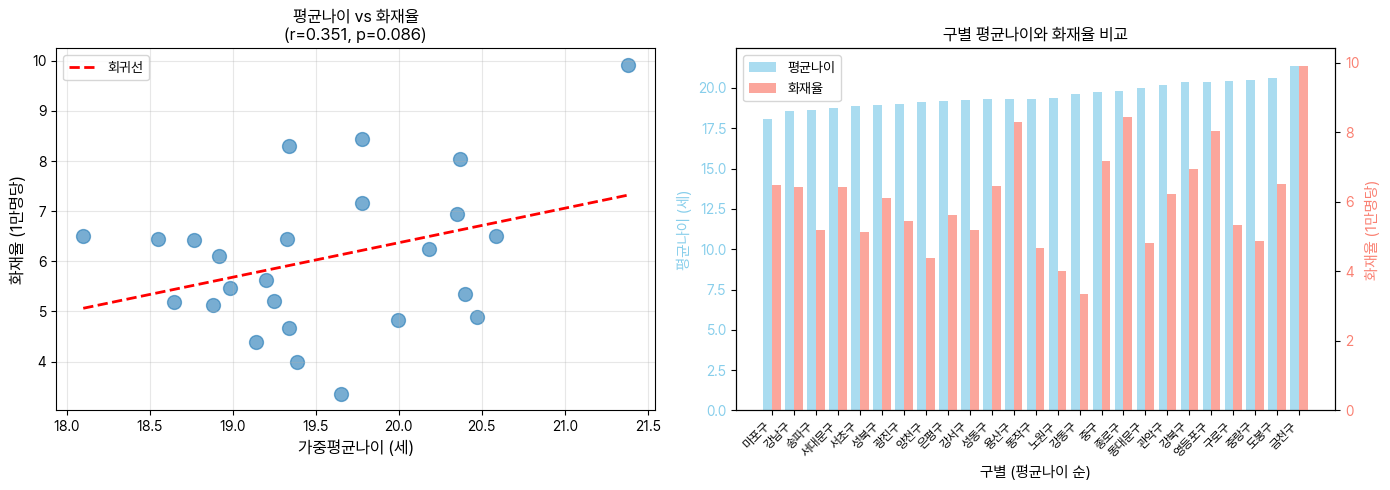

평균나이-화재율 비교 그래프 저장 완료: imgs/평균나이_화재율.png


In [32]:
# 연령대와 화재율 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 산점도와 회귀선
ax1 = axes[0]
ax1.scatter(fire_rate_age['가중평균나이'], fire_rate_age['화재율(1만명당)'], s=100, alpha=0.6)

# 회귀선
z_age = np.polyfit(fire_rate_age['가중평균나이'], fire_rate_age['화재율(1만명당)'], 1)
p_age = np.poly1d(z_age)
x_line_age = np.linspace(fire_rate_age['가중평균나이'].min(), fire_rate_age['가중평균나이'].max(), 100)
ax1.plot(x_line_age, p_age(x_line_age), "r--", linewidth=2, label='회귀선')

ax1.set_xlabel('가중평균나이 (세)', fontsize=12)
ax1.set_ylabel('화재율 (1만명당)', fontsize=12)
ax1.set_title(f'평균나이 vs 화재율\n(r={corr_age_fire[0]:.3f}, p={corr_age_fire[1]:.3f})', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 구별 평균나이와 화재율 비교
ax2 = axes[1]
sorted_data = fire_rate_age.sort_values('가중평균나이')
x_pos = np.arange(len(sorted_data))

ax2_twin = ax2.twinx()

bar1 = ax2.bar(x_pos - 0.2, sorted_data['가중평균나이'], 0.4, label='평균나이', color='skyblue', alpha=0.7)
bar2 = ax2_twin.bar(x_pos + 0.2, sorted_data['화재율(1만명당)'], 0.4, label='화재율', color='salmon', alpha=0.7)

ax2.set_xlabel('구별 (평균나이 순)', fontsize=11)
ax2.set_ylabel('평균나이 (세)', fontsize=11, color='skyblue')
ax2_twin.set_ylabel('화재율 (1만명당)', fontsize=11, color='salmon')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sorted_data.index, rotation=45, ha='right', fontsize=9)
ax2.set_title('구별 평균나이와 화재율 비교', fontsize=12)
ax2.tick_params(axis='y', labelcolor='skyblue')
ax2_twin.tick_params(axis='y', labelcolor='salmon')

# 범례
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('imgs/평균나이_화재율.png', dpi=300, bbox_inches='tight')
plt.show()

print("평균나이-화재율 비교 그래프 저장 완료: imgs/평균나이_화재율.png")

In [37]:
# 연령대 그룹별 분석 (연령대 컬럼 인덱스 기반)
# available_cols는 age_agg의 연령대 컬럼(0~13)로 가정
available_cols = age_agg.columns[1:15].tolist()
print("Available age columns:", available_cols)

# 인덱스 기반 그룹 매핑 (available_cols의 위치를 사용)
age_idx_groups = {
    '10대': [1, 2],            # 10-14, 15-19
    '20-30대': [3, 4, 5],      # 20-24,25-29,30-34
    '40-50대': [7, 8, 9],      # 40-44,45-49,50-54
    '60대': [11, 12],          # 60-64,65-69
    '70세이상': [13]
}

# 초기화
age_demographic = pd.DataFrame()
age_demographic['구명'] = age_agg.index
age_demographic['총인구'] = age_agg.iloc[:, 0].values
age_demographic['가중평균나이'] = age_agg['가중평균나이'].values

# 그룹별 인구 및 비중 계산
for group_name, idxs in age_idx_groups.items():
    # 인덱스를 available_cols 범위로 변환 (age_agg 컬럼 위치 기준)
    cols = []
    for idx in idxs:
        # available_cols list indexing: 0..13 correspond to age_agg.columns[1:15]
        pos = idx - 1  # mapping where idx=1 -> available_cols[0]
        if 0 <= pos < len(available_cols):
            cols.append(available_cols[pos])
    if cols:
        age_demographic[f'{group_name}_인구'] = age_agg[cols].sum(axis=1).values
        age_demographic[f'{group_name}_비중(%)'] = (age_demographic[f'{group_name}_인구'] / age_demographic['총인구'] * 100).round(2)

# 화재율 추가
age_demographic['화재율(1만명당)'] = age_demographic['구명'].map(fire_rate_age['화재율(1만명당)'].to_dict())

print('\n=== 구별 연령대 분석 (요약) ===')
print(age_demographic.head().to_string())

# 연령대별 화재율 상관계수
print('\n=== 연령대 비중 vs 화재율 상관계수 ===')
for group_name in age_idx_groups.keys():
    col_name = f'{group_name}_비중(%)'
    if col_name in age_demographic.columns:
        corr_val = age_demographic[col_name].corr(age_demographic['화재율(1만명당)'])
        print(f"{group_name}: {corr_val:.4f}")
    else:
        print(f"{group_name}: 컬럼 없음")


Available age columns: ['남자0세부터9세생활인구수', '남자10세부터14세생활인구수', '남자15세부터19세생활인구수', '남자20세부터24세생활인구수', '남자25세부터29세생활인구수', '남자30세부터34세생활인구수', '남자35세부터39세생활인구수', '남자40세부터44세생활인구수', '남자45세부터49세생활인구수', '남자50세부터54세생활인구수', '남자55세부터59세생활인구수', '남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '남자70세이상생활인구수']

=== 구별 연령대 분석 (요약) ===
    구명           총인구     가중평균나이        10대_인구  10대_비중(%)     20-30대_인구  20-30대_비중(%)     40-50대_인구  40-50대_비중(%)       60대_인구  60대_비중(%)     70세이상_인구  70세이상_비중(%)  화재율(1만명당)
0  강남구  1.573308e+07  18.547208  1.007576e+06       6.40  1.645364e+06         10.46  2.163617e+06         13.75  838312.5724       5.33  255195.3320         1.62   6.437391
1  강동구  1.223733e+07  19.651274  7.731063e+05       6.32  1.025614e+06          8.38  1.566238e+06         12.80  819163.0812       6.69  279137.2611         2.28   3.353672
2  강북구  6.909925e+06  20.351136  3.408322e+05       4.93  6.144178e+05          8.89  7.999825e+05         11.58  511188.9983       7.40  167031.8551         2.42   6.94

In [ ]:
# 연령대 그룹별 상관관계 시각화
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

age_groups_list = ['20대', '30대', '40대', '50대', '60대이상']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, (age_group, color) in enumerate(zip(age_groups_list, colors)):
    ax = axes[idx]
    age_pct_col = f'{age_group}_비중(%)'
    
    # 데이터 준비
    corr_data = pd.DataFrame({
        age_pct_col: age_demographic[age_pct_col],
        '화재율(1만명당)': gu_stats.loc[age_demographic.index, '화재율(1만명당)']
    }).dropna()
    
    # 산점도
    ax.scatter(corr_data[age_pct_col], corr_data['화재율(1만명당)'], 
               s=100, alpha=0.6, color=color)
    
    # 회귀선
    if len(corr_data) > 2:
        z = np.polyfit(corr_data[age_pct_col], corr_data['화재율(1만명당)'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(corr_data[age_pct_col].min(), corr_data[age_pct_col].max(), 100)
        ax.plot(x_line, p(x_line), "r--", linewidth=2)
        
        corr = age_group_correlations[age_group]
        ax.set_title(f'{age_group} 비중 vs 화재율\n(r={corr[0]:.3f}, p={corr[1]:.3f})', fontsize=11)
    
    ax.set_xlabel(f'{age_group} 비중 (%)', fontsize=10)
    ax.set_ylabel('화재율 (1만명당)', fontsize=10)
    ax.grid(True, alpha=0.3)

# 6번째 서브플롯: 전체 상관계수 비교
ax_summary = axes[5]
age_groups_list_plot = ['20대', '30대', '40대', '50대', '60대이상']
correlations = [age_group_correlations[ag][0] for ag in age_groups_list_plot]
p_values = [age_group_correlations[ag][1] for ag in age_groups_list_plot]

bars = ax_summary.bar(age_groups_list_plot, correlations, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# 유의성 표시
for i, (bar, pval) in enumerate(zip(bars, p_values)):
    significance = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'NS'
    ax_summary.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   significance, ha='center', va='bottom', fontsize=11, fontweight='bold')

ax_summary.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax_summary.set_ylabel('Pearson 상관계수', fontsize=11)
ax_summary.set_title('연령대별 화재율 상관계수 비교', fontsize=12, fontweight='bold')
ax_summary.set_ylim([min(correlations) - 0.15, max(correlations) + 0.2])
ax_summary.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('imgs/연령대별_화재율_상관분석.png', dpi=300, bbox_inches='tight')
plt.show()

print("연령대별 상관분석 그래프 저장 완료: imgs/연령대별_화재율_상관분석.png")

In [ ]:
# 연령대 분석 결과 저장
age_summary = pd.DataFrame({
    '분석 항목': ['평균나이 vs 화재율', '20대_비중', '30대_비중', '40대_비중', '50대_비중', '60대이상_비중'],
    '상관계수': [
        corr_age_fire[0],
        age_group_correlations['20대'][0],
        age_group_correlations['30대'][0],
        age_group_correlations['40대'][0],
        age_group_correlations['50대'][0],
        age_group_correlations['60대이상'][0]
    ],
    'p-value': [
        corr_age_fire[1],
        age_group_correlations['20대'][1],
        age_group_correlations['30대'][1],
        age_group_correlations['40대'][1],
        age_group_correlations['50대'][1],
        age_group_correlations['60대이상'][1]
    ],
    '유의도': [
        '***' if corr_age_fire[1] < 0.001 else '**' if corr_age_fire[1] < 0.01 else '*' if corr_age_fire[1] < 0.05 else 'NS',
        '***' if age_group_correlations['20대'][1] < 0.001 else '**' if age_group_correlations['20대'][1] < 0.01 else '*' if age_group_correlations['20대'][1] < 0.05 else 'NS',
        '***' if age_group_correlations['30대'][1] < 0.001 else '**' if age_group_correlations['30대'][1] < 0.01 else '*' if age_group_correlations['30대'][1] < 0.05 else 'NS',
        '***' if age_group_correlations['40대'][1] < 0.001 else '**' if age_group_correlations['40대'][1] < 0.01 else '*' if age_group_correlations['40대'][1] < 0.05 else 'NS',
        '***' if age_group_correlations['50대'][1] < 0.001 else '**' if age_group_correlations['50대'][1] < 0.01 else '*' if age_group_correlations['50대'][1] < 0.05 else 'NS',
        '***' if age_group_correlations['60대이상'][1] < 0.001 else '**' if age_group_correlations['60대이상'][1] < 0.01 else '*' if age_group_correlations['60대이상'][1] < 0.05 else 'NS'
    ]
})

print("=== 연령대 분석 결과 요약 ===")
print(age_summary.to_string(index=False))

# 결과 저장
age_summary.to_csv('results/연령대_화재율_상관분석.csv', index=False, encoding='utf-8-sig')
age_demographic.to_csv('results/구별_연령대_분석.csv', encoding='utf-8-sig')

print("\n결과 저장 완료:")
print("  - results/연령대_화재율_상관분석.csv")
print("  - results/구별_연령대_분석.csv")